### 1 Data loading and pre-processing <a name="data"></a>

In [2]:
import fairlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

# from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

from imblearn.ensemble import BalancedBaggingClassifier

from fairlearn.widget import FairlearnDashboard
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import (
    group_summary, selection_rate, selection_rate_group_summary,
    demographic_parity_difference, demographic_parity_ratio,
    balanced_accuracy_score_group_summary, roc_auc_score_group_summary,
    equalized_odds_difference, difference_from_summary)

# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: difference_from_summary(
                balanced_accuracy_score_group_summary(y_true, x, sensitive_features=group)), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: difference_from_summary(
                roc_auc_score_group_summary(y_true, x, sensitive_features=group)), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [3]:
df_orig = pd.read_csv(pd.read_csv("/Users/henilvedant/Desktop/Employee.csv")
df_orig.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


First, we will encode categorical features: department, region, education, gender, recruitment_channel.

In [4]:
df = df_orig.copy()
df.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [5]:
obj_columns = df.select_dtypes(['object']).columns
for c in obj_columns:
    df[c] = df[c].astype('category')

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

df.dtypes

employee_id               int64
department                 int8
region                     int8
education                  int8
gender                     int8
recruitment_channel        int8
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

The data set contains missing values that should be imputed before training ML models.

In [6]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education                  0
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

Let's impute the missing values in the data set.

In [7]:
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['previous_year_rating'] = df['previous_year_rating'].fillna(df['previous_year_rating'].mode()[0])

print("Number of missing values:", df.isnull().sum().sum())

Number of missing values: 0


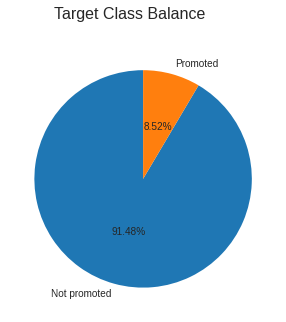

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('seaborn-white')

df['is_promoted'].value_counts().plot(kind = 'pie',
                                      autopct = '%.2f%%',
                                      startangle = 90,
                                      labels = ['Not promoted','Promoted'],
                                      pctdistance = 0.5)
plt.axis('off')

plt.suptitle('Target Class Balance', fontsize = 16)
plt.show()

In [9]:
# Creating a label vector and a feature vector
X = df.drop(["employee_id","is_promoted"], axis=1)
y = df["is_promoted"]

A = df_orig['department']

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     y, 
                                                                     A,
                                                                     test_size = 0.2,
                                                                     random_state=0,
                                                                     stratify=y)

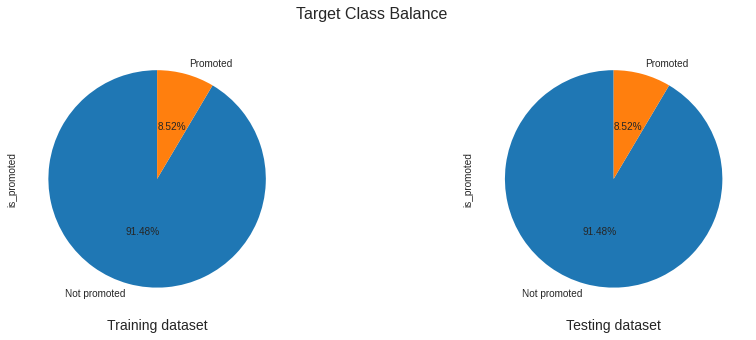

In [10]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('seaborn-white')

plt.subplot(1, 2, 1)

y_train.value_counts().plot(kind = 'pie',
                            autopct = '%.2f%%',
                            startangle = 90,
                            labels = ['Not promoted','Promoted'],
                            pctdistance = 0.5)

plt.xlabel('Training dataset', fontsize = 14)

plt.subplot(1, 2, 2)

y_test.value_counts().plot(kind = 'pie',
                           autopct = '%.2f%%',
                           startangle = 90,
                           labels = ['Not promoted','Promoted'],
                           pctdistance = 0.5)

plt.xlabel('Testing dataset', fontsize = 14)

plt.suptitle('Target Class Balance', fontsize = 16)
plt.show()

In [11]:
clf = BalancedBaggingClassifier()

In [12]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.884


The mean ROC AUC is acceptable, and we can fit the whole training data to the estimator.

In [13]:
clf.fit(X_train, y_train)

test_scores = clf.predict_proba(X_test)[:, 1]

# Predictions (0 or 1) on test set
y_pred = (test_scores >= np.mean(y_test)) * 1

print('Mean ROC AUC: %.3f' % roc_auc_score(y_test, test_scores))

Mean ROC AUC: 0.886


Let's check a global importance of features used by the model. To do so, we will calculate the mean importance across the estimators of the `BalancedBaggingClassifier`.

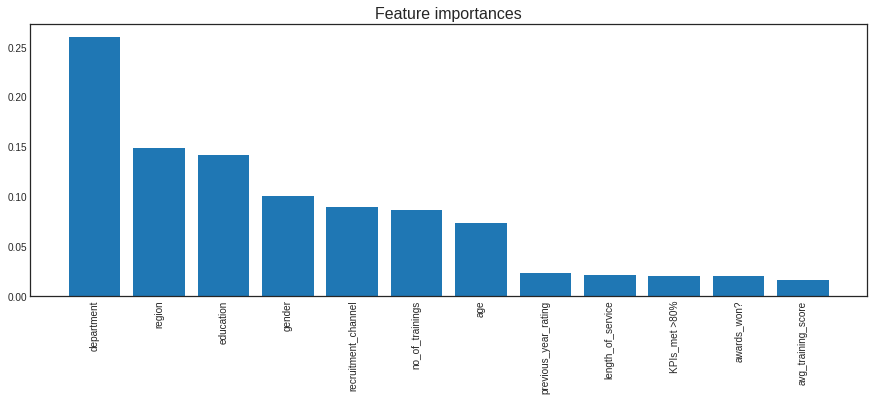

In [14]:
importances = np.mean([est.steps[1][1].feature_importances_ for est in clf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.style.use('seaborn-white')
plt.title("Feature importances", fontsize = 16)
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
models_dict = {"Unmitigated": (y_pred, test_scores)}
get_metrics_df(models_dict, y_test, A_test)

,Unmitigated
Overall selection rate,0.482394
Demographic parity difference,0.544718
Demographic parity ratio,0.353371
-----,
Overall balanced error rate,0.222359
Balanced error rate difference,0.299049
Equalized odds difference,0.587354
------,
Overall AUC,0.885601
AUC difference,0.245183


In [16]:
gs = group_summary(roc_auc_score, y_test, y_pred, sensitive_features=A_test)
gs

{'overall': 0.7776411273274233,
 'by_group': {'Analytics': 0.5774035569258535,
  'Finance': 0.7547393364928909,
  'HR': 0.8289473684210527,
  'Legal': 0.764102564102564,
  'Operations': 0.7656481025135535,
  'Procurement': 0.7960540395933654,
  'R&D': 0.6173469387755102,
  'Sales & Marketing': 0.8764524957012425,
  'Technology': 0.7072806005565975}}

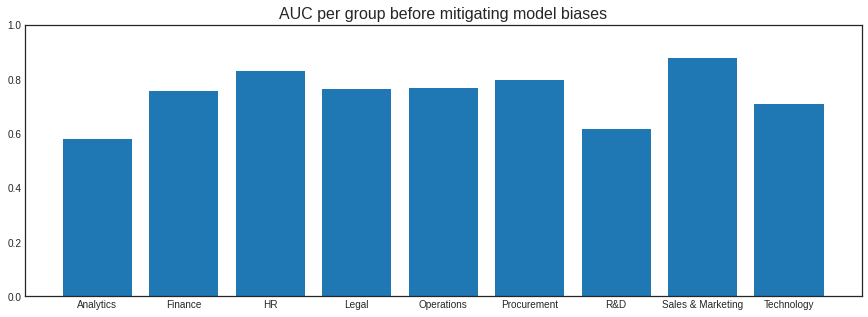

In [17]:
plt.figure()
plt.style.use('seaborn-white')
plt.title("AUC per group before mitigating model biases", fontsize = 16)
plt.bar(range(len(gs["by_group"])), list(gs["by_group"].values()), align='center')
plt.xticks(range(len(gs["by_group"])), list(gs["by_group"].keys()))
plt.ylim(0, 1)
plt.show()

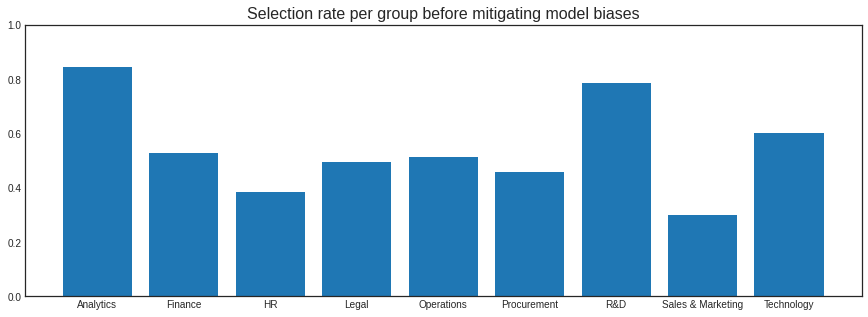

In [18]:
srg = selection_rate_group_summary(y_test, y_pred, sensitive_features=A_test)

plt.figure()
plt.style.use('seaborn-white')
plt.title("Selection rate per group before mitigating model biases", fontsize = 16)
plt.bar(range(len(srg["by_group"])), list(srg["by_group"].values()), align='center')
plt.xticks(range(len(srg["by_group"])), list(srg["by_group"].keys()))
plt.ylim(0, 1)
plt.show()

In [19]:
FairlearnDashboard(sensitive_features=A_test, sensitive_feature_names=['department'],
                   y_true=y_test,
                   y_pred={"Unmitigated": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0…

In [20]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3,
    'random_state': 9
}

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
clf = lgb.LGBMClassifier(**lgb_params)
mitigator = ExponentiatedGradient(clf, constraint)
mitigator.fit(X_train, y_train, sensitive_features=A_train)

y_pred_mitigated = mitigator.predict(X_test)

In [21]:
models_dict = {"ExponentiatedGradient": (y_pred_mitigated, y_pred_mitigated)}
get_metrics_df(models_dict, y_test, A_test)

,ExponentiatedGradient
Overall selection rate,0.015052
Demographic parity difference,0.0254854
Demographic parity ratio,0.194661
-----,
Overall balanced error rate,0.418107
Balanced error rate difference,0.15467
Equalized odds difference,0.300699
------,
Overall AUC,0.581893
AUC difference,0.15467


In [22]:
gs = group_summary(roc_auc_score, y_test, y_pred_mitigated, sensitive_features=A_test)
gs

{'overall': 0.5818926491904038,
 'by_group': {'Analytics': 0.5443346743871259,
  'Finance': 0.5735294117647058,
  'HR': 0.5483870967741935,
  'Legal': 0.6111111111111112,
  'Operations': 0.5610044725807345,
  'Procurement': 0.5821428571428572,
  'R&D': 0.49489795918367346,
  'Sales & Marketing': 0.5852328594608994,
  'Technology': 0.6495677895208779}}

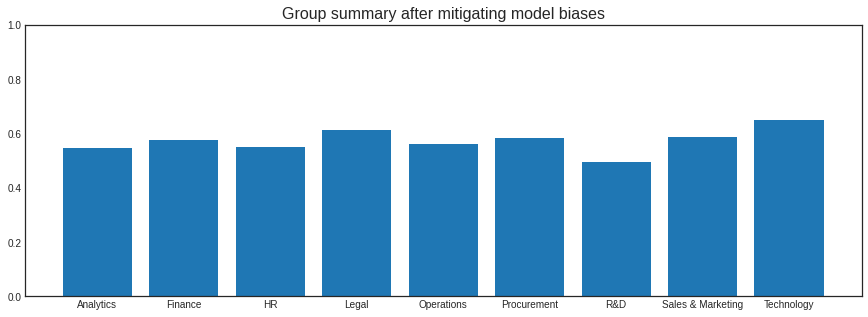

In [23]:
plt.figure()
plt.style.use('seaborn-white')
plt.title("Group summary after mitigating model biases", fontsize = 16)
plt.bar(range(len(gs["by_group"])), list(gs["by_group"].values()), align='center')
plt.xticks(range(len(gs["by_group"])), list(gs["by_group"].keys()))
plt.ylim(0, 1)
plt.show()

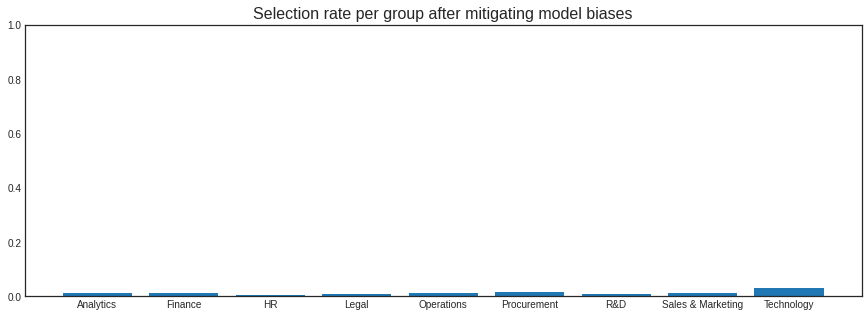

In [24]:
srg = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=A_test)

plt.figure()
plt.style.use('seaborn-white')
plt.title("Selection rate per group after mitigating model biases", fontsize = 16)
plt.bar(range(len(srg["by_group"])), list(srg["by_group"].values()), align='center')
plt.xticks(range(len(srg["by_group"])), list(srg["by_group"].keys()))
plt.ylim(0, 1)
plt.show()